-------------------------------------------------


This notebook is part of the [q4p (Quantum Computing for Programmers) series](https://github.com/CarloLepelaars/q4p). The original notebook can be found on [Github](https://github.com/CarloLepelaars/q4p/blob/main/nbs/04-deutsch.ipynb).

-------------------------------------------------

# 4. Deutsch-Josza

In this lesson you will learn:
- **Query algorithms**
- Deutsch's algorithm, which provides a clear quantum advantage on determining if a function is constant or balanced.
- The **Deutsch-Josza algorithm**, which generalizes Deutsch's algorithm to multiple qubits.
- **BONUS: Bernstein-Vazirani**

Deutsch's algorithm is an essential algorithm to understand advantages of quantum computing. It leverages **superposition** and **interference** to evaluate if a function is constant or balanced in one pass. Classical algorithms require multiple passes to determine this. This is achieved through a phenomenon called **phase kickback**. Deutsch's algorithm is the simplest case that can be implemented with 1 qubit and evaluate a binary function ($f: \{0,1\} \rightarrow \{0,1\}$). The Deutsch-Josza algorithm generalizes this to multiple qubits ($f: \{0,1\}^n \rightarrow \{0,1\}$).

Deutsch's algorithm is an example of **query algorithms**. These are algorithms where a **black box** function $f$ is integrated in the quantum circuit and used to evaluate that function. We will see this query model in many quantum algorithms with quantum advantage, like **Grover's algorithm** and **Shor's algorithm**.



## Deutsch's algorithm

Deutsch's algorithm is take in a binary function $f$ and determine if it is **constant** or **balanced**.

**Constant** means that the function always return the same values, for the binary input $0$ and $1$ this means that $f(0) = f(1)$. A different way to think about this is that $f(x) = 0$ or $f(x) = 1$ for all $x$.

**Balanced** means that different inputs give different values with a 50/50 distribution. For the binary input $0$ and $1$ this means that $f(0) \neq f(1)$. Examples of balanced functions are a bit flip or the identity function.

Measuring the first qubit as $|0\rangle$ indicates a constant function. 

Measuring the first qubit as $|1\rangle$ indicates a balanced function.

The function $f$ is integrated in the quantum circuit. Around $f$ we place $H$ gates to put the qubit in superposition and get quantum interference effects. We will use the `DeutschOracle` from `skq`.


In [1]:
# skq is used to construct and convert quantum circuits
!pip install -Uqq skq

In [2]:
import numpy as np

from skq.gates.qubit import H, X, I, Measure, DeutschOracle, DeutschJozsaOracle, QubitGate
from skq.circuits import Concat, Circuit

In [3]:
def deutsch_circuit(f) -> Circuit:
    """ 
    Deutsch's algorithm
    :param f: Binary function that maps a single bit to a single bit.
    :return: skq Circuit that implements Deutsch's algorithm.
    """
    return Circuit([
    # Prepare 2nd qubit in |1⟩ state
    Concat([I(), X()]),
    # Put qubits in superposition to leverage interference
    Concat([H(), H()]),
    # Apply oracle to get phase kickback
    DeutschOracle(f),
    Concat([H(), I()]),
    Measure()
])

def deutsch_balanced_func(x):
        """f(0)=0, f(1)=1"""
        return x

def deutsch_constant_func(x):
        """Always 0: f(0)=0, f(1)=0"""
        return 0

No to_qiskit defined for 'DeutschOracle'. Initializing as UnitaryGate.


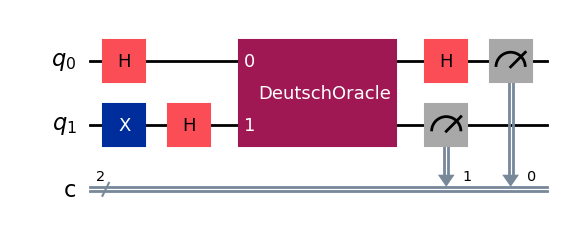

In [4]:
deutsch_balanced_circuit = deutsch_circuit(deutsch_balanced_func)
deutsch_balanced_circuit.draw(output='mpl')

`DeutschOracle` ($U_f$) here now represents a balanced function. For this oracle we expect to see a **phase kickback** effect. This is an interference effect which features a phase flip of first qubit. Think of `DeutschOracle` as a controlled gates with the first qubit as control qubit and the second qubit as target qubit. Because both qubits are in superposition, we get an effect where the second qubit remains unchanged, while the first qubit is flipped if the function that the oracle represents is balanced. This is called **destructive interference**. The second qubit in this circuit is called an **ancilla qubit**. This is the case because we only use it for the oracle. After the we can discard it, because we only need to measure the first qubit to determine if a function is balanced.

We start out the system in the state $|00\rangle$ and apply an $X$ gate on the second qubit to get $|01\rangle$:

$$
\psi_0 = |00\rangle
$$


$$
\psi_1 = |01\rangle
$$

Then apply the $H$ gate on both qubits to get:

$$
\psi_2 = H|01\rangle = |+-\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle) |-\rangle = \frac{1}{2}(|00\rangle - |01\rangle + |10\rangle - |11\rangle)
$$

This intermediate state results in an equal $25\%$ probability between $|00\rangle$, $|01\rangle$, $|10\rangle$, and $|11\rangle$.


Note that the encoded `DeutschOracle` for a balanced function is the same as a $CX$ gate.

In [5]:
deutsch_balanced_circuit[2]

DeutschOracle([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
               [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])

By applying this oracle we get the phase kickback effect. We denote the `DeutschOracle` by $U_f$ to represent its black box nature:

$$
|\psi_3\rangle = U_f |+-\rangle =  \frac{1}{\sqrt{2}}(|0\rangle |-\rangle + |1\rangle|-\rangle) = \frac{1}{\sqrt{2}} (U_f|0\rangle |-\rangle + U_f|1\rangle|-\rangle)
$$

$$
= \frac{1}{\sqrt{2}} (-1)^{f(0)}|0\rangle |-\rangle + (-1)^{f(1)}|1\rangle|-\rangle)
$$

Don't worry if the derivation is not entirely clear. Note that this quantum state evaluates $f(0)$ and $f(1)$ at the same time. For our balanced function its the case that $f(0) \neq f(1)$. After the oracle we can discard the second qubit, so consider only the first qubit from here"

$$
|\psi_{3 f(0) \neq f(1)}\rangle = \frac{1}{\sqrt{2}} (|0\rangle- |1\rangle) = |-\rangle
$$

The last quantum gate we apply is $H$ on the first qubit.

$$
|\psi_{4}\rangle = H|-\rangle = H\frac{1}{\sqrt{2}}(|0\rangle - |1\rangle) = |1\rangle
$$





In [6]:
deutsch_balanced_circuit([1, 0, 0, 0]).round(3)

array([0. , 0. , 0.5, 0.5])

The result is $|10\rangle$ or $|11\rangle$ with equal probability. The first qubit is $1$ so we can conclude that the function is balanced. Note that the second qubit starting in the $|1\rangle$ state, but now is in a superposition state. This is a feature of the phase kickback effect.

A classical algorithm would require two passes, because it would need to verify both input $0$ and $1$ to determine if the function is balanced. The quantum algorithm only requires one pass to get the correct answer with $100\%$ certainty, given that there is no noise in the quantum system. This is a clear demonstration of quantum advantage even if the use cases of Deutsch's algorithm are limited. We will see later that this phenomenon of phase kickback can become powerful as it is used in **Shor's algorithm** to break encryption by factoring large numbers.

Now let's look at the case for a constant function.

No to_qiskit defined for 'DeutschOracle'. Initializing as UnitaryGate.


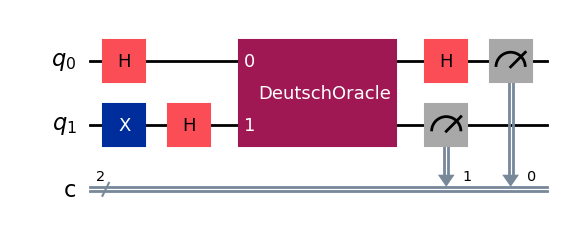

In [7]:
deutsch_constant_circuit = deutsch_circuit(deutsch_constant_func)
deutsch_constant_circuit.draw(output='mpl')

If we look at the encoded matrix of our oracle for a constant function, we see that it is the identity gate $I$ on two qubits.

In [8]:
# Deutsch Oracle for constant function is the same as the identity gate I.
deutsch_constant_circuit[2]

DeutschOracle([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

In [9]:
deutsch_constant_circuit([1, 0, 0, 0]).round(3)

array([0.5, 0.5, 0. , 0. ])

The result is $|00⟩$ or $|01⟩$ with equal probability. The first qubit is $0$ so we can conclude that the function is constant. 

Note that we don't need to know the function $f$ to determine if it is constant or balanced. We only need to have the ability to query the oracle in our circuit. A classical analogy would be having access to an API somewhere on the Internet. We can query the API with different inputs and evaluate the output.

You might be curious how the actual oracle is structured.

## Deutsch-Josza algorithm

The **Deutsch-Josza algorithm** is very similar to Deutsch's algorithm. The same phase kickback phenomenon is now applied to multiple qubits. Again we apply $H$ gates on every qubit before and after the oracle to get a quantum superposition and leverage interference effects. Note that as we generalize to function with multiple qubits it becomes possible to encounter function that are neither constant nor balanced. For example where 25% of the inputs return $0$ and 75% return $1$. For this algorithm to work we need to make sure that our function $f$ is either constant or balanced, else the algorithm will give unpredictable results. This necessity is called the **promise**. **Deutsch-Josza** is therefore a **promise problem**. In code this **promise** is achieved with an `assert` statement.

Here is the formal definition of a balanced and constant function for **Deutsch-Josza** on $n$ qubits:

- Balanced function: $f(x_1, \ldots, x_n) = 1$ for exactly $2^{n-1}$ inputs and $f(x_1, \ldots, x_n) = 0$ for the remaining $2^{n-1}$ inputs.
- Constant function: $f(x_1, \ldots, x_n) = 0$ for all inputs or $f(x_1, \ldots, x_n) = 1$ for all inputs.

Here the quantum advantage becomes more clear compared to Deutsch's algorithm. A deterministic classical algorithm requires $2^{n-1} + 1$ queries to determine if the function is constant or balanced. A probabilistic classical algorithm still requires a few queries. The Deutsch-Josza algorithm requires only $1$ query.

In [10]:
def deutsch_josza_circuit(f, n_bits: int) -> Circuit:
    """
    Deutsch-Josza algorithm
    :param f: Binary function that maps a single bit to a single bit.
    :return: skq Circuit that implements Deutsch-Josza algorithm.
    """
    return Circuit([
        Concat([I() for _ in range(n_bits-1)] + [X()]),
        Concat([H() for _ in range(n_bits)]),
        DeutschJozsaOracle(f, n_bits=n_bits),
        Concat([H() for _ in range(n_bits)]),
        Measure()
    ])

def deutsch_josza_balanced_function(x):
    """Balanced function: f(0)=0, f(1)=0, f(2)=0, f(3)=0, 
                          f(4)=0, f(5)=0, f(6)=0, f(7)=0,
                          f(8)=1, f(9)=1, f(10)=1, f(11)=1,
                          f(12)=1, f(13)=1, f(14)=1, f(15)=1"""
    return 1 if x >= 8 else 0  # Half of the states are 1

def deutsch_josza_constant_function(x):
    """f(x) = 0 for all x"""
    return 0  # Always 0

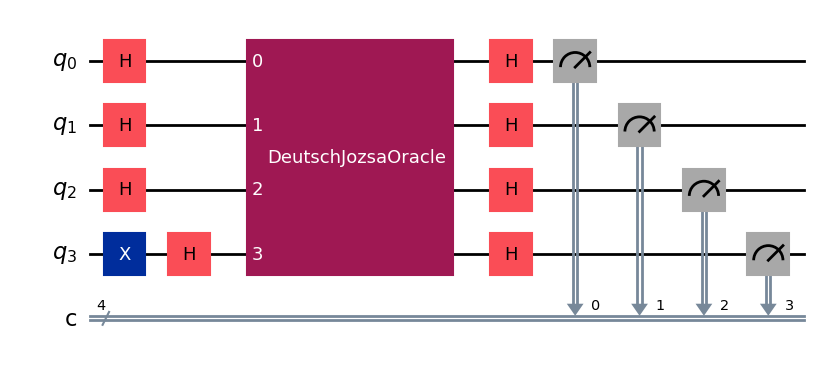

In [11]:
n_qubits = 4
balanced_deutsch_josza_circuit = deutsch_josza_circuit(deutsch_josza_balanced_function, n_qubits)
balanced_deutsch_josza_circuit.draw(output='mpl')

If the function is balanced the oracle will represent a $CCCZ$ gate, a controlled Z gate with $3$ control qubits and $1$ target qubit, so the qubits are entangled in the oracle. Apart from this the structure of the Deutsch and Deutsch-Josza algorithms are the same. Even though we work with multiple qubits and measure them, we only need to look at the first qubit to determine if the function is constant or balanced. For 4 qubits the balanced function should give a result of $|1000⟩$ and a constant function $|0000⟩$.

In query algorithms like Deutsch-Josza we always initialize the qubits in the zero state. For 4 qubits this is $|0000⟩$.

In [12]:
four_qubit_zero_state = [1] + [0]*(2**n_qubits-1)

In [13]:
balanced_deutsch_josza_circuit(four_qubit_zero_state).round(3)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

The resulting statevector represents $|1001⟩$. The first qubit is $1$, so the function is balanced. 

For the constant function the output should be $|0001⟩$.

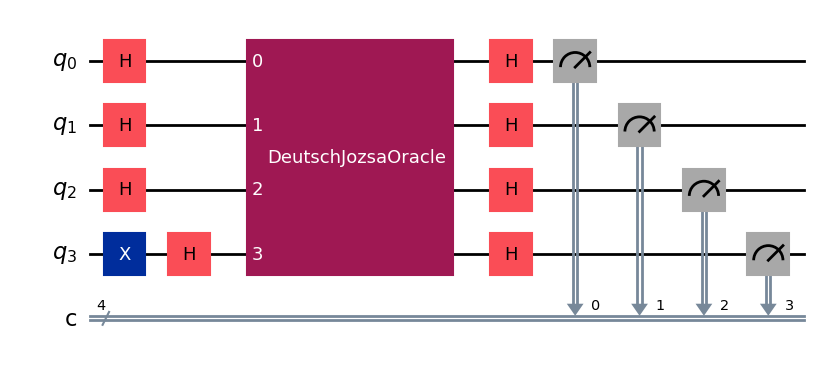

In [14]:
constant_deutsch_josza_circuit = deutsch_josza_circuit(deutsch_josza_constant_function, n_qubits)
constant_deutsch_josza_circuit.draw(output='mpl')

In [15]:
constant_deutsch_josza_circuit(four_qubit_zero_state).round(3)

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

The resulting statevector represents $|0001⟩$. The first qubit is $0$, so the function is constant.

Don't worry if the idea of an oracle still sounds a bit abstract. In this notebook we have focused on understanding and analyzing the algorithms to simulate an oracle on a classical computer. In real quantum systems the oracle is a black box, for which we don't know the exact mechanics. Over time you will become more comfortable with the query algorithm model and discover why it is powerful to develop quantum algorithms in this way. 

Next we will apply the query model to achieve a quadratic speedup in unstructured search problems. This algorithm is called **Grover's algorithm**. Later we will discover how to achieve near exponential speedups to break encryption by factoring large numbers through **Shor's algorithm**.

# BONUS: Bernstein-Vazirani

The Deutsch-Josza algorithm can be used to solve multiple problems in quantum computing. Not only can it be used to determine if a function is constant or balanced, but it can also solve the **Bernstein-Vazirani** problem. The only difference is that the oracle for Bernstein-Vazirani encodes a bitstring instead of a function.

There is [an excellent blog post on Bernstein-Vazirani](https://medium.com/quantum-untangled/the-bernstein-vazirani-algorithm-quantum-algorithms-untangled-67e58d4a5096) that explains the problem in detail. Your knowledge of Deutsch-Josza from this notebook will help you to understand this blog post.

Continue with the next lesson:
- [On Github](https://github.com/CarloLepelaars/q4p/blob/main/nbs/05-grover.ipynb)
- [On Kaggle](https://www.kaggle.com/code/carlolepelaars/q4p-5-grover-s-algorithm)

-------------------------------------------------

This notebook is part of the [q4p (Quantum Computing for Programmers) series](https://github.com/CarloLepelaars/q4p). The original notebook can be found on [Github](https://github.com/CarloLepelaars/q4p/blob/main/nbs/04-deutsch.ipynb).

-------------------------------------------------